<a href="https://colab.research.google.com/github/Vaycold/statistics_seminar/blob/main/covid19_tweet/loaded_data/binary_relevance%20with%20GaussianNB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer    
from google.colab import files

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split


warnings.filterwarnings('ignore')

os.environ['KAGGLE_USERNAME'] = 'kimgodbang'
os.environ['KAGGLE_KEY'] = '1c0e1716b23829d4381dcbced37ba49b'

!rm *.*
!kaggle competitions download -c sentiment-analysis-of-covid-19-related-tweets

train_df = pd.read_csv('training.csv')
test_df = pd.read_csv('validation.csv')

for module in ['stopwords', 'punkt', 'wordnet'] :
    nltk.download(module)

  0% 0.00/254k [00:00<?, ?B/s]
100% 254k/254k [00:00<00:00, 37.2MB/s]
  0% 0.00/518k [00:00<?, ?B/s]
100% 518k/518k [00:00<00:00, 68.1MB/s]
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [68]:
def labelsplit(labels) :
    
    label = labels.replace(' ',',').split(',')
    for idx, lab in enumerate(label) :
        label[idx] = int(lab)
    return label

In [69]:
train_df['label']  = train_df['Labels'].apply(lambda x :  labelsplit(x))

In [70]:
onehot = np.zeros((5000,11))
for i in range(5000) : # 0~5000 row
    for j in train_df.label[i] : # j = value   
        onehot[i,j]  = 1
cols_target = ['0','1','2','3','4','5','6','7','8','9','10']
onehot = pd.DataFrame(onehot, columns=cols_target)

In [71]:
train_df = pd.concat(
    [train_df, onehot], axis=1
).drop(['ID','Labels', 'label'],axis=1)

## EDA

 Tweet 중 단어가 가장 많은 tweet의 단어 수 : 30
 Tweet 중 단어가 가장 적은 tweet의 단어 수 : 1
 평균 tweet 의 길이 : 16.9214
 tweet 의 길이의 중간값 : 17.0




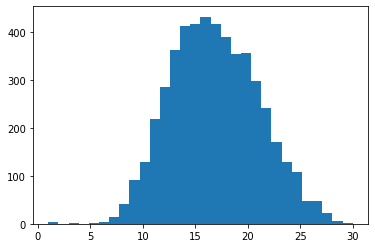

In [72]:
# 단어의 갯수

word_count = train_df['Tweet'].apply(lambda x : len(x.split(' ')))
print(f' Tweet 중 단어가 가장 많은 tweet의 단어 수 : {np.max(word_count)}')
print(f' Tweet 중 단어가 가장 적은 tweet의 단어 수 : {np.min(word_count)}')
print(f' 평균 tweet 의 길이 : {np.mean(word_count)}')
print(f' tweet 의 길이의 중간값 : {np.median(word_count)}')
print('\n')
plt.hist(word_count, bins=30)
plt.show()

## 텍스트 클렌징

In [73]:
stop = stopwords.words('english')
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i) for i in text]
    return lem_text
def  clean_text(df, text_field='Tweet', new_text_field_name='clean_tweet'):
    df[new_text_field_name] = df[text_field].str.lower()
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x : x.lower())
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x : x.replace('corona','covid'))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x : x.replace('coronavirus','virus'))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"\d+", "", elem))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x: word_tokenize(x))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x: word_lemmatizer(x))
    df[new_text_field_name] = df[new_text_field_name].apply(lambda x: ' '.join(x))
    return df

In [74]:
def clean_df(df) :
    DF = clean_text(df, 'Tweet', 'clean_tweet')
    try :
        DF = DF[['clean_tweet','0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']]
        DF.columns = ['Tweet','0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    except :
        DF = DF[['ID','clean_tweet']]
        DF.columns = ['ID','Tweet']
    
    return DF
    
def one(x) :
    if x > 2 :
        return 1
    else :
        return 0

In [75]:
train_df = clean_df(train_df)
test_df = clean_df(test_df)

In [76]:
train_df.head(2)

,Tweet,0,1,2,3,4,5,6,7,8,9,10
0,joke hop plane rn well covid lol,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,banmediahouse whose responsible spreading fake...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [77]:
test_df.head(2)

,ID,Tweet
0,5001,forgot math test failing teacher opening back ...
1,5002,covid effected came delhi bihar lakhisarai dis...


In [78]:
# 단어수 
print(len(set([word for words in train_tweet for word in words.split()])))

8517


 Tweet 중 단어가 가장 많은 tweet의 단어 수 : 21
 Tweet 중 단어가 가장 적은 tweet의 단어 수 : 1
 평균 tweet 의 길이 : 10.1706
 tweet 의 길이의 중간값 : 10.0




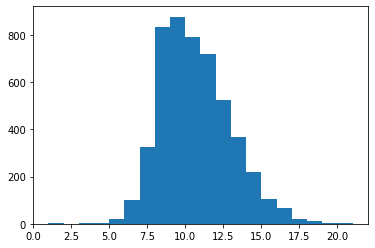

In [79]:
word_count = train_df['Tweet'].apply(lambda x : len(x.split(' ')))
print(f' Tweet 중 단어가 가장 많은 tweet의 단어 수 : {np.max(word_count)}')
print(f' Tweet 중 단어가 가장 적은 tweet의 단어 수 : {np.min(word_count)}')
print(f' 평균 tweet 의 길이 : {np.mean(word_count)}')
print(f' tweet 의 길이의 중간값 : {np.median(word_count)}')
print('\n')
plt.hist(word_count, bins=20)
plt.show()

In [80]:
np.quantile(word_count, 0.025)

6.0

 Tweet 중 단어가 가장 많은 tweet의 단어 수 : 20
 Tweet 중 단어가 가장 적은 tweet의 단어 수 : 1
 평균 tweet 의 길이 : 10.1968
 tweet 의 길이의 중간값 : 10.0




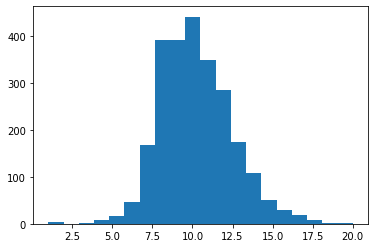

In [81]:
word_count = test_df['Tweet'].apply(lambda x : len(x.split(' ')))
print(f' Tweet 중 단어가 가장 많은 tweet의 단어 수 : {np.max(word_count)}')
print(f' Tweet 중 단어가 가장 적은 tweet의 단어 수 : {np.min(word_count)}')
print(f' 평균 tweet 의 길이 : {np.mean(word_count)}')
print(f' tweet 의 길이의 중간값 : {np.median(word_count)}')
print('\n')
plt.hist(word_count, bins=20)
plt.show()

## 토큰화 및 패딩

In [82]:
train_tweet = train_df['Tweet'].values
test_tweet = test_df['Tweet'].values

In [83]:
train_tweet[:2]

array(['joke hop plane rn well covid lol',
       'banmediahouse whose responsible spreading fake communal story pandemic covid situation'],
      dtype=object)

In [84]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_tweet)

train_token = tokenizer.texts_to_sequences(train_tweet)
train_token[0]

[8, 1838, 2382, 357, 96, 1, 133]

In [85]:
print(train_tweet[0])
print(train_token[0])

joke hop plane rn well covid lol
[8, 1838, 2382, 357, 96, 1, 133]


In [86]:
word_vocab = tokenizer.word_index
#print(word_vocab)

In [87]:
print(f'단어 전체의 갯수 {len(word_vocab)}')

단어 전체의 갯수 8517


In [88]:
maxlen = 21 # 전처리 후 최댓값
train_pad = pad_sequences(train_token, maxlen = maxlen, padding = 'pre')
print(train_tweet[0])
print(train_token[0])
print(train_pad[0])

joke hop plane rn well covid lol
[8, 1838, 2382, 357, 96, 1, 133]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    8 1838 2382  357   96    1  133]


In [89]:
print(type(train_pad))
print(train_pad.shape)
print(train_pad[0].shape)

<class 'numpy.ndarray'>
(5000, 21)
(21,)


## 벡터화


### SENTENCEPIECE

In [90]:
!pip install sentencepiece
import sentencepiece as spm

In [91]:
train_tweet.shape

(5000,)

In [92]:
with open('./full_tweet.txt', 'w', encoding='utf-8') as f:
    for line in train_tweet :
        if len(str(line).strip()) == 0 : continue
        try : 
            f.write(line + '\n')
        except : continue

In [93]:
!cat full_tweet.txt | head -n2

joke hop plane rn well covid lol
banmediahouse whose responsible spreading fake communal story pandemic covid situation


In [94]:
spm.SentencePieceTrainer.train('--input=full_tweet.txt --model_prefix=m --vocab_size=5000')

In [95]:
sp = spm.SentencePieceProcessor()
sp.load('m.model')

True

In [96]:
train_df['bow'] = train_df['Tweet'].apply(lambda x : sp.encode_as_ids(str(x)))
test_df['bow'] = test_df['Tweet'].apply(lambda x : sp.encode_as_ids(str(x)))

In [97]:
train_df.head(2)

,Tweet,0,1,2,3,4,5,6,7,8,9,10,bow
0,joke hop plane rn well covid lol,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[22, 369, 2018, 542, 164, 3, 222]"
1,banmediahouse whose responsible spreading fake...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"[1055, 2401, 2059, 148, 458, 1402, 58, 98, 4, ..."


In [98]:
test_df.head(2)

,ID,Tweet,bow
0,5001,forgot math test failing teacher opening back ...,"[1465, 4023, 42, 828, 4, 5, 1353, 412, 4, 85, ..."
1,5002,covid effected came delhi bihar lakhisarai dis...,"[3, 2761, 7, 379, 718, 2801, 233, 1929, 1562, ..."


In [99]:
train_pad = pad_sequences(train_df['bow'].values, maxlen=25)
test_pad = pad_sequences(test_df['bow'].values, maxlen=25)

In [100]:
train_pad.shape

(5000, 25)

In [101]:
train_df.head()

,Tweet,0,1,2,3,4,5,6,7,8,9,10,bow
0,joke hop plane rn well covid lol,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[22, 369, 2018, 542, 164, 3, 222]"
1,banmediahouse whose responsible spreading fake...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"[1055, 2401, 2059, 148, 458, 1402, 58, 98, 4, ..."
2,im waiting someone say covid thing april fool ...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"[19, 92, 4, 61, 39, 26, 3, 63, 14, 15, 22]"
3,liar proven day night time lie truth covid,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"[970, 233, 1347, 31, 29, 377, 41, 464, 1244, 3]"
4,new u covidvirus death toll reach nearly new d...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,"[33, 17, 6, 34, 219, 79, 450, 1476, 12, 33, 34..."


In [102]:
pd.DataFrame(train_pad)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,369,2018,542,164,3,222
1,0,0,0,0,0,0,0,1055,2401,2059,148,458,1402,58,98,4,309,1186,521,9,96,3,64,594,138
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,92,4,61,39,26,3,63,14,15,22
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,970,233,1347,31,29,377,41,464,1244,3
4,0,0,0,0,0,0,33,17,6,34,219,79,450,1476,12,33,34,444,46,60,749,120,3,6,506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0,0,0,0,0,0,0,0,0,88,5,1898,437,372,1870,9,439,4,3,34,89,39,47
4996,0,0,0,0,0,0,136,1254,321,7,95,3,11,46,46,29,133,54,8,161,1863,1863,1863,273,319
4997,0,0,0,0,0,0,0,0,0,0,0,0,0,557,584,27,738,32,12,423,17,773,1218,39,3
4998,0,0,0,0,0,517,29,158,16,420,7,6,159,20,1055,566,64,3044,918,304,243,791,1256,1055,566


In [103]:
x_train_pseudo = pd.concat(
    [train_df, pd.DataFrame(train_pad)], axis=1
)
x_test_pseduo = pd.concat(
    [test_df, pd.DataFrame(test_pad)], axis=1
)
x_test_pseduo.head()

,ID,Tweet,bow,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,5001,forgot math test failing teacher opening back ...,"[1465, 4023, 42, 828, 4, 5, 1353, 412, 4, 85, ...",0,0,0,0,0,0,0,0,0,1465,4023,42,828,4,5,1353,412,4,85,104,193,3,5,196,167
1,5002,covid effected came delhi bihar lakhisarai dis...,"[3, 2761, 7, 379, 718, 2801, 233, 1929, 1562, ...",379,718,2801,233,1929,1562,621,968,139,298,16,4631,16,5,2959,3015,25,525,263,177,484,218,972,329,1332
2,5003,make covid end na,"[67, 3, 124, 27]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,67,3,124,27
3,5004,imagine covidvirus pandemic big april fool jok...,"[294, 176, 6, 96, 141, 14, 15, 22, 68, 36, 817...",0,0,0,0,0,0,0,0,0,0,0,0,294,176,6,96,141,14,15,22,68,36,817,7,17
4,5005,howdy ana get married covidvirus update gov,"[2797, 135, 5, 566, 21, 2673, 7, 6, 261, 297]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2797,135,5,566,21,2673,7,6,261,297


In [112]:
# using binary relevance

In [111]:
!pip install scikit-multilearn

     |████████████████████████████████| 92kB 4.4MB/s 


In [118]:
train_pad[:4000].shape

(4000, 25)

In [124]:
train_pad

array([[   0,    0,    0, ...,  164,    3,  222],
       [   0,    0,    0, ...,   64,  594,  138],
       [   0,    0,    0, ...,   14,   15,   22],
       ...,
       [   0,    0,    0, ..., 1218,   39,    3],
       [   0,    0,    0, ..., 1256, 1055,  566],
       [   0,    0,    0, ...,  268,  445,    3]], dtype=int32)

In [123]:
train_df[cols_target]

,0,1,2,3,4,5,6,7,8,9,10
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
4996,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4997,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
4998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [137]:
pd.DataFrame(train_pad[:4000])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,369,2018,542,164,3,222
1,0,0,0,0,0,0,0,1055,2401,2059,148,458,1402,58,98,4,309,1186,521,9,96,3,64,594,138
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,92,4,61,39,26,3,63,14,15,22
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,970,233,1347,31,29,377,41,464,1244,3
4,0,0,0,0,0,0,33,17,6,34,219,79,450,1476,12,33,34,444,46,60,749,120,3,6,506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0,0,0,0,0,0,0,0,0,0,66,43,941,21,76,3,11,66,213,18,1187,2861,622,179,73
3996,0,0,0,0,0,0,0,0,0,0,0,0,19,44,27,18,56,632,26,40,4,423,184,128,6
3997,0,0,0,0,0,0,0,0,0,0,0,72,122,2263,25,3205,10,4,28,3,383,11,1445,16,11
3998,0,0,0,0,0,0,0,0,0,211,9,3,160,22,360,55,430,5,338,1699,83,5,196,5,507


In [139]:
train_df[cols_target][:4000]

,0,1,2,3,4,5,6,7,8,9,10
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3995,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3996,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3997,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [172]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

classifier = BinaryRelevance(GaussianNB())

# train 
classifier.fit(pd.DataFrame(train_pad[:4000]), train_df[cols_target][:4000])

BinaryRelevance(classifier=GaussianNB(priors=None, var_smoothing=1e-09),
                require_dense=[True, True])

In [173]:
predictions = classifier.predict(pd.DataFrame(train_pad[4000:]))
predictions.shape

(1000, 11)

In [174]:
train_df[cols_target][4000:].shape

(1000, 11)

In [175]:
from sklearn.metrics import f1_score, accuracy_score
accuracy_score(train_df[cols_target][4000:], predictions)

0.0

In [176]:
f1_score(train_df[cols_target][4000:], predictions, average = 'macro')

0.18615087213307835

In [177]:
print(predictions.toarray())

[[0. 0. 1. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 1.]
 ...
 [0. 0. 1. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 1.]]


In [180]:
pd.DataFrame(predictions.toarray())

,0,1,2,3,4,5,6,7,8,9,10
0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
4,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
996,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
997,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
998,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
